In [1]:
#More or less general imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
#from past.utils import old_div
import time

#Imports for Creating WebSky Maps 
import h5py    
import healpy as hp
from pixell import enmap,utils, reproject, bunch, curvedsky, enplot
import os, sys
import dill as dl
#from cosmology import *
from scipy.interpolate import *
#Unit conversion
from astropy import units as u
from astropy.constants import k_B, h

#Imports for Torch
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

#Creating Stamps
from astropy import wcs
from astropy.nddata import Cutout2D
import pickle as pk
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
import yaml
from pixell import enmap,utils, reproject, enplot
from scipy import interpolate
import random
from astropy.nddata import block_reduce, block_replicate
import ipyparallel as ipp
from mpi4py import MPI
from PIL import Image
from astLib import astWCS, astImages
from scipy import ndimage
from pixell.enmap import sky2pix
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import proj_plane_pixel_scales
from astroquery.skyview import SkyView
import astropy.io.fits as pyfits
from stamping_utils import autotiler, getTileCoordsDict, make_jpg, normalize_map, make_mask_wise, _make_jpg, make_stamp, make_mask
import glob

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
def generate_coords():
    # Arccosine helper function
    def arccos_arange(start, finish, steps):
        """
        Converts an arange array of angles (in degrees) to their arccosine values in radians.
        Returns:
        Array of arccosine values in radians.
        """
        degrees_array = np.arange(start, finish, steps)
        radians_array = np.deg2rad(degrees_array)
        # (arccosine values will be between -1 and 1)
        cosine_values = np.cos(radians_array)
        y = np.arccos(cosine_values)
        return y
    
    # Coordinates
    x = np.arange(0, 361 * utils.degree, 1.5 * utils.degree)
    y = arccos_arange(-69, 70, 1.5)
    
    # Array of coordinates
    decy, rax = np.meshgrid(y, x)
    
    # Flatten the meshgrid arrays and combine them into pairs of positions
    coords = np.array([decy.ravel(), rax.ravel()]).T
    coords = np.unique(coords, axis=0)
    
    return coords
    
coords = generate_coords()
print(coords)

[[0.         0.        ]
 [0.         0.02617994]
 [0.         0.05235988]
 ...
 [1.20427718 6.23082543]
 [1.20427718 6.25700537]
 [1.20427718 6.28318531]]


In [3]:
#Global Constants
TCMB    = 2.726 #Kelvin
TCMB_uK = 2.726e6 #micro-Kelvin
hplanck = 6.626068e-34 #MKS
kboltz  = 1.3806503e-23 #MKS
clight  = 299792458.0 #MKS
#Access to WebSky Data
path    = "/mnt/welch/USERS/cwhitaker/maps/websky/"
#Unit conversion provided by Mat
def dBnudT(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz)
    X = hplanck*nu/(kboltz*TCMB)
    return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK * 1e26

def ItoDeltaT(nu_ghz):
    return 1./dBnudT(nu_ghz)


#Creating a websky map of some frequency
def create_websky_map(freq):
    # Shape and WCS of the maps
    #For FullSky
    shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(0.5 / 60))

    #Unit conversion provided by Mat
    def dBnudT(nu_ghz):
        nu = 1.e9*np.asarray(nu_ghz)
        X = hplanck*nu/(kboltz*TCMB)
        return (2.*hplanck*nu**3.)/clight**2. * (np.exp(X))/(np.exp(X)-1.)**2. * X/TCMB_uK * 1e26

    def ItoDeltaT(nu_ghz):
        return 1./dBnudT(nu_ghz)
    #Access to WebSky Data
    #path = "/mnt/welch/USERS/cwhitaker/maps/websky/"
    
    # CMB
    alm = hp.read_alm(path + 'lensed_alm.fits', hdu=(1, 2, 3))
    cmb_map = curvedsky.alm2map(alm.astype(np.complex128)[0, :], enmap.empty(shape, wcs, dtype=np.float32))
    
    # kSZ Effect
    ksz_map = hp.read_map(path + "ksz.fits")
    npix = ksz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    ksz_map = reproject.healpix2map(ksz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    # tSZ Effect
    tsz_map = hp.read_map(path + "tsz_8192.fits")
    npix = tsz_map.size  # assuming single healpix map
    nside = hp.npix2nside(npix)
    lmax = 3 * nside
    tsz_map = reproject.healpix2map(tsz_map, shape=cmb_map.shape, wcs=cmb_map.wcs, lmax=lmax)
    
    if 90 <= freq <= 90.2:
        cib_map    = enmap.read_map(path + "cib_90.2_car.fits")
        radio_map  = enmap.read_map(path + "/map_radio_0.5arcmin_f90.2.fits")
        tsz_factor = -4.2840 * 1e6 #tSZ conversion for 90 GHz
        cib_factor = 2.5947 * 1e3
    elif 150 <= freq <= 153:
        cib_map    = enmap.read_map(path + "cib_153_car.fits")
        radio_map  = enmap.read_map(path + "/map_radio_0.5arcmin_f143.0.fits")
        tsz_factor = -2.7685 * 1e6 #tSZ conversion for 150 GHz
        cib_factor = 4.6831 * 1e3
    # Conversion factors
    elif 217 <= freq <= 225:
        cib_map = enmap.read_map(path + "cib_217_car.fits")
        radio_map = enmap.read_map(path + "/map_radio_0.5arcmin_f217.0.fits")
        tsz_factor = 3.1517 * 1e5 #tSZ conversion for 220 GHz
        cib_factor = 2.0676 * 1e3
        #cib_225 = 2.0716 * 1e3
    
    # CIB conversions to temperature map in uK
    # Combine maps
    websky_map = radio_map*ItoDeltaT(freq) + cmb_map + ksz_map + tsz_map*tsz_factor + cib_map*cib_factor 
    return websky_map, wcs

In [4]:
omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81

c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

In [5]:
#Access to WebSky data
path = "/mnt/welch/USERS/cwhitaker/maps/websky/"

In [22]:
cluster_catalog=open(path + 'halos.pksc')
N = np.fromfile(cluster_catalog,count=3,dtype=np.int32)[0]
# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
N = 2463790
catalog=np.fromfile(cluster_catalog,count=N*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))
x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc
#print(catalog)

In [23]:
# Constants
rho      = 2.775e11*omegam*h**2 # Msun/Mpc^3
# this is M200m (mean density 200 times mean) in Msun
M        = 4*np.pi/3.*rho*R**3
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
redshift = zofchi(chi)

In [24]:
theta,phi = hp.vec2ang(np.column_stack((x,y,z))) # in (not with utils.degree) radians

In [25]:
ra      = phi
dec     = np.pi/2. - theta

In [26]:
#Limit to how bright/massive the clusters can be
#New cut at 1e14
#Less bright / massive clusters = 3.0e14
cluster_cut = 2.0e14

cluster_flags = np.where((M >= cluster_cut))[0]
#Limit on parameters of clusters
M            = M[cluster_flags]
redshift     = redshift[cluster_flags]
cluster_decs = dec[cluster_flags] * 180/np.pi
cluster_ras  = ra[cluster_flags] * 180/np.pi
r = R[cluster_flags]

In [27]:
chi = chi[cluster_flags]

In [28]:
print(r.shape)

(246381,)


### Creating Stamps and Mask

Creating tiles and corresponding stamps centered around celestial coordinates. In this code 313 boxes are created

#### Individual Frequency cutouts

def freq_stamper(ras, decs):
    comm = MPI.COMM_WORLD
    myrank = comm.Get_rank()
    nproc = comm.Get_size()
    freqs = ["090", "150", "220"]
    #Radius of box
    dr = 30*u.arcmin
    count = 0
    
    for i in range(myrank, len(ras), nproc):
        print(i, end="\r")
        offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
        ra_cent = cluster_ras[i]*u.deg+offset_ra
        dec_cent = cluster_decs[i]*u.deg+offset_dec

        ra_min, ra_max = ra_cent - dr, ra_cent + dr
        dec_min, dec_max = dec_cent - dr, dec_cent + dr
    
        if ra_max < ra_min:
            ra_min -= 360
        
        box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
    
        #Make stamp of box
        stamp, cur_wcs = make_stamp('/mnt/welch/USERS/jorlo/maps/20240323_simple/act_planck_*_f*_daynight_map_srcfree.fits', box, freqs, normalize = False)
        if type(stamp) == int: continue
        #np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}".format(str(i).zfill(4)), jpg)
        enmap.write_map("/mnt/welch/USERS/cwhitaker/ml-clusters/websky_tiles/freq_tiles/indv_freq_{}.fits".format(count), stamp)
        mask = make_mask(stamp, cluster_ras, cluster_decs, box, cur_wcs, size=2.4)
        #print(mask.shape)
        np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_masks/{}_mask".format(str(i).zfill(4)), mask)
        count += 1
    

with ipp.Cluster(controller_ip="*", engines="mpi", n=24) as rc:
    view = rc.broadcast_view()
    r = view.apply_sync(freq_stamper(ras, decs))
    print("\n".join(r))

comm = MPI.COMM_WORLD
myrank = comm.Get_rank()
nproc = comm.Get_size()
freqs = ["090", "150", "220"]

dr = 30*u.arcmin
    
for i in range(myrank, len(cluster_ras[:3]), nproc):
    print(i, end="\r")
    offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
    ra_cent = cluster_ras[i]*u.deg+offset_ra
    dec_cent = cluster_decs[i]*u.deg+offset_dec

    ra_min, ra_max = ra_cent - dr, ra_cent + dr
    dec_min, dec_max = dec_cent - dr, dec_cent + dr
    
    if ra_max < ra_min:
        ra_min -= 360
        
    box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]])# * utils.degree
    print(box)    
        #Make stamp of box
    stamp, cur_wcs = make_stamp('/mnt/welch/USERS/cwhitaker/maps/websky/websky_f*_map.fits', box, freqs, normalize= False)
    if type(stamp) == int: continue
    
        #np.savez_compressed("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}".format(str(i).zfill(4)), jpg)
   # enmap.write_map("/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{}.fits".format(str(i).zfill(4)), stamp)
  #  mask = make_mask(stamp, act_catalog, [[ra_min.value, ra_max.value], [dec_min.value, dec_max.value]], cur_wcs, size = 4.8)

In [29]:
from astropy.cosmology import Planck15 as cosmo
d_A = cosmo.angular_diameter_distance(z=redshift)
d_C = cosmo.comoving_distance(z=redshift)
d_C = d_C.value
d_A = d_A.value
theta = (r / d_A) * (180 * 60 / np.pi)
print(d_A)
print(theta)

[ 848.37257162  515.39545626 1021.35202279 ...  963.87491317 1479.85341655
 1731.3620764 ]
[111.42438742 183.03498429  92.01153603 ...  37.90417001  24.68814516
  21.10177502]


In [30]:
comm = MPI.COMM_WORLD
myrank = comm.Get_rank()
nproc = comm.Get_size()
freqs = ["090", "150", "220"]

dr = 10*u.arcmin
offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
ra_cent = cluster_ras[246379]*u.deg+offset_ra
dec_cent = cluster_decs[246379]*u.deg+offset_dec
ra_min, ra_max = ra_cent - dr, ra_cent + dr
dec_min, dec_max = dec_cent - dr, dec_cent + dr
box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
stamp, cur_wcs = make_stamp('/mnt/welch/USERS/cwhitaker/maps/websky/websky_f*_map.fits', box, freqs, normalize = False)
mask = make_mask(stamp, cluster_ras, cluster_decs, box, cur_wcs, size = 3)
#print(chi[0],theta[0])

tan:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21.00,21.00]}


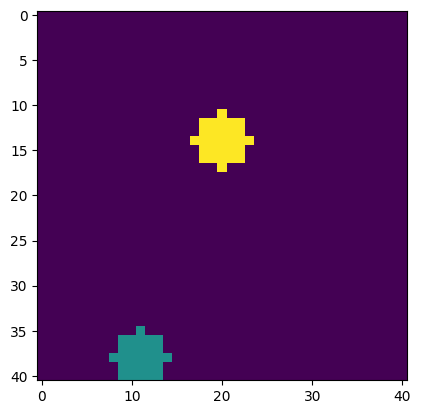

In [31]:
#lims=10000
plt.imshow(mask)#, vmin=-lims, vmax=lims)
plt.savefig('mask_stamp_size')

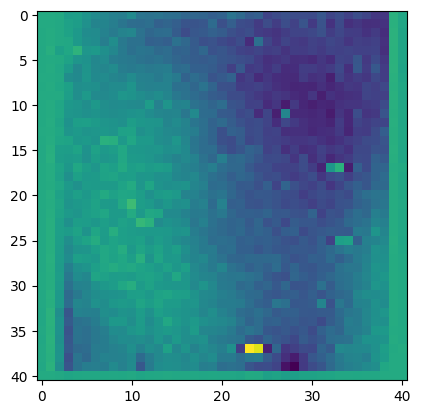

In [32]:
#lims=1000
plt.imshow(stamp[0])#, vmin=-lims, vmax=lims)
plt.savefig('freq_stamp_size')

/tmp/ipykernel_526699/444339520.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


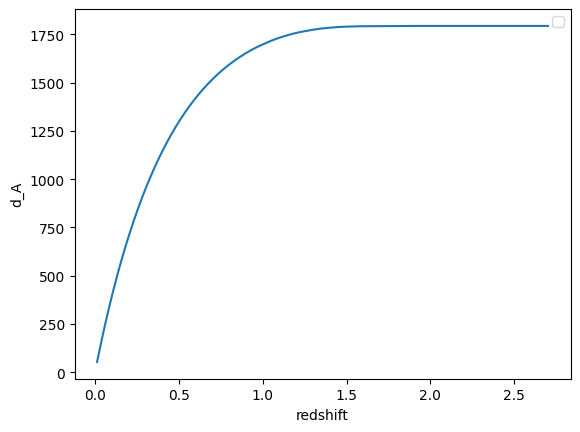

In [33]:
redshift = np.sort(redshift)
d_A = np.sort(d_A)
plt.plot(redshift,d_A)
plt.xlabel("redshift")
plt.ylabel("d_A")
plt.savefig('d_A vs redshift')
plt.legend()
# Show the plot
plt.show()